# Fraud Detection Model
## Table Of Contents

1. **[Introdução](#06-introduction)**
- **[Questões Iniciais](#06-init-quest)**
- **[Análise Exloratória dos Dados](#06-eda)**
    1. **[Distrbuição de Probabilidade da Variável Fraude](#06-target-dist)**
    - **[Relação da Variáveis de Fraude e Inadimplência](#06-fraud-default)**
    - **[Análise de Navegador](#06-browser)**
- **[Métricas](#06-metrics)**
- ***[Feature Engineering](#06-feat-eng)***
- **[Modelagem](#06-modeling)**

# Introdução <a name="06-introduction"></a>
Neste notebook, nós iremos explorar o problema de indentificação das solicitações fradulentas de cartão de crédito. Nós começaremos por definir o problema que queremos modelar e, em seguida, realizaramos uma análise exploratória dos dados a fim de extrair *insights* para o modelagem posterior. Na seção 4, faremos uma análise do relacionamento das métricas utilizadas no modelo com as métricas de performance de negócio e em seguida, apresentaremos a etapa de criação de caracterísicas utilizadas na modelagem. Por fim, apresentaremos o modelo final obtido e seus resultados.

## Identificação de Solicitações Fraudulentas
O problema consiste em identificar, dentre as solicitações de abertura de relacionamento com o banco, as solicitações que configurão fraude. Por solicitação fraudulenta, nesse caso, entende-se como aquelas solicitações que foram realizadas indevidamente em nome de terceiros. Uma vez que o fraudador recebe o cartão de crédito em nome de outra pessoa e, por isso, não possuí as obrigações das cobranças, assume-se que ele dará um prejuízo ao banco, no valor da fatura.  
As fraudes, nesse problema, são sinalizadas com dois identificadores. O primeiro identifica os casos em que a solicitação de cartão se dá no nome de conhecidos ou familiares e no segundo marcador, não há relação próxima entre o fraudador e a pessoa cujo nume está sendo indevidamente utilizado.

Para iniciar, vamos formular algumas questões relacionadas ao problema em questão

# Questões Iniciais <a name="06-init-quest"></a>
O problema em questão parecer apresentar alguma similaridade com o problema de modelagem de Risco de Crédito. Além de o conjunto de dados fornecidos ser o mesmo e ambos os problemas se caracterizarem por um problema de classificação, intuitivamente parece fazer sentido que os casos de fraude sejam classificados como inadimplentes.  
Seguindo essa linha, começaremos por formular algumas questões que devem ser respondidas na ánalise exploratória:
1. Qual o relacionamento entre as variáveis `target_fraud` e `target_default` ?
2. Uma solicitação que utiliza dados falsos, poderia partir de uma região diferente da residência do indivíduo que teve os dados indevidamente utilizados. Podemos observar esse efeito nos dados?


# Análise Exploratória dos Dados <a name="06-eda"></a>

## Distrbuição de Probabilidade da Variável Fraude <a name="06-target-dist"></a>
Começaremos analisando a distribuição da variável de fraude:

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")


import sys, os
sys.path.insert(0,os.path.realpath('..'))
pd.options.display.max_columns = 50

import src.data_util as du
import src.pipeline_transformers as pp
import src.data_viz as dv
color1 = (97/255, 47/255, 116/255, 1.)

raw_acquisition, _, _ = du.load_data('../data')
acquisition, spend = du.load_data_preprocessed('../data')
main_color = (97/255, 47/255, 116/255, 1.)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading formatted geocoded file...


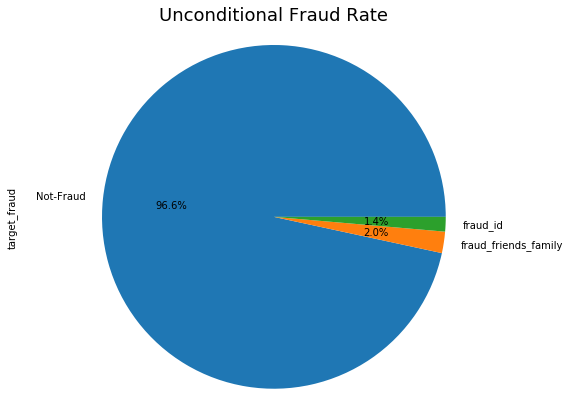

In [3]:
fraud = raw_acquisition['target_fraud'].fillna('Not-Fraud').value_counts()/raw_acquisition.shape[0]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
fraud.plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.axis('equal')
_ = ax.set_title('Unconditional Fraud Rate', fontdict={'fontsize':18})

Notamos que, nos dados em questão, temos um problema de desbalanceamento de classes mais sério do que na modelagem de Risco de Crédito. Já, de antemão, iremos eliminar a possibilidade de abordar o problema como uma classificação multi-categoria e atacá-lo como classificação binária.

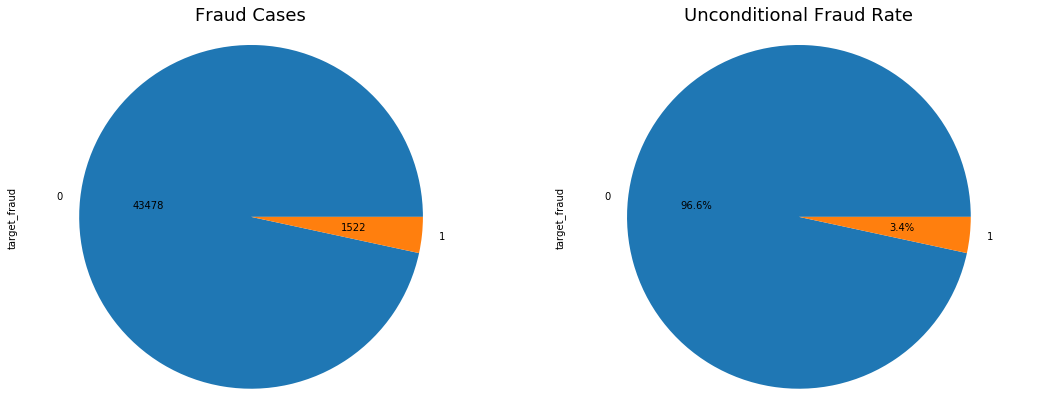

In [4]:
fraud_cases = acquisition['target_fraud'].value_counts()
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(121)
fraud_cases.plot(kind='pie', autopct=lambda p: '{:.0f}'.format(p*acquisition.shape[0]/100), ax=ax)
ax.axis('equal')
_ = ax.set_title('Fraud Cases', fontdict={'fontsize':18})
ax = fig.add_subplot(122)
fraud = acquisition['target_fraud'].value_counts()/acquisition.shape[0]
fraud.plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.axis('equal')
_ = ax.set_title('Unconditional Fraud Rate', fontdict={'fontsize':18})

## Relação da Variáveis de Fraude e Inadimplência <a name="06-fraud-default"></a>

Vamos, agora analisar o relacionamento entre as variáveis de Fraude e Inadimplência. Na tabela abaixo, podemos avaliar, nas colunas, a ocorrência percentual de casos de fraudes e, nas linhas, como essas ocorrências foram sinalizadas em relação à inadimplência.

In [5]:
from sklearn.metrics import confusion_matrix
targets = acquisition[['target_fraud','target_default']].dropna().astype(np.uint8)
targets_relationship = pd.DataFrame(np.zeros((2,2)), columns=['fraud','not_fraud'],index=['default','not_default'])
targets_relationship.loc['default','fraud'] = targets.loc[(targets['target_fraud']>0)&(targets['target_default']>0),:].shape[0]
targets_relationship.loc['default','not_fraud'] = targets.loc[(targets['target_fraud']==0)&(targets['target_default']>0),:].shape[0]
targets_relationship.loc['not_default','fraud'] = targets.loc[(targets['target_fraud']>0)&(targets['target_default']==0),:].shape[0]
targets_relationship.loc['not_default','not_fraud'] = targets.loc[(targets['target_fraud']==0)&(targets['target_default']==0),:].shape[0]
targets_relationship = targets_relationship/targets.shape[0]
display(targets_relationship)

,fraud,not_fraud
default,0.024005,0.135574
not_default,0.008505,0.831916


Notamos que, dos 3.4% de solicitações fraudulentas, 2.4% foram sinalizadas como inadimplente e 0.8% se mantiveram adimplentes. (Observe que 0.2% das solicitações que foram sinalizadas com fraude possuem a variável de inadimplência ausente).
Daqui concluímos que aproximadamente um terço dos casos de fraude foram descobertos antes, ou sem, da ocorrência de inadimplência. Consideramos a **pergunta 1** respondida.
Essa divisão nos leva a uma pergunta em relação ao padrão de gastos dos clientes. Qual o tempo médio necessário para identificação de fraude ou ocorrência de inadimplência?

In [6]:
last_month = spend.groupby('ids')['month'].max().reset_index()
idx = targets.loc[(targets['target_fraud']==0)&(targets['target_default']==0),:]
time_to_fraud_default = raw_acquisition.loc[idx.index].merge(last_month, how='left',on='ids')['month'].apply(['min','mean','max','count']).to_frame(name='Not_fraud_Not_Default')
idx = targets.loc[(targets['target_fraud']>0)&(targets['target_default']==0),:]
time_to_fraud_default['fraud_Not_default'] = raw_acquisition.loc[idx.index].merge(last_month, how='left',on='ids')['month'].apply(['min','mean','max','count']).to_frame(name='fraud_Not_Default')
idx = targets.loc[(targets['target_fraud']==0)&(targets['target_default']>0),:]
time_to_fraud_default['Not_fraud_default'] = raw_acquisition.loc[idx.index].merge(last_month, how='left',on='ids')['month'].apply(['min','mean','max','count']).to_frame(name='fraud_Not_Default')
idx = targets.loc[(targets['target_fraud']>0)&(targets['target_default']>0),:]
time_to_fraud_default['fraud_default'] = raw_acquisition.loc[idx.index].merge(last_month, how='left',on='ids')['month'].apply(['min','mean','max','count']).to_frame(name='fraud_Not_Default')
display(time_to_fraud_default)

,Not_fraud_Not_Default,fraud_Not_default,Not_fraud_default,fraud_default
min,11.000000,11.000000,2.000000,2.000000
mean,23.009503,23.129577,8.108853,8.016966
max,35.000000,35.000000,14.000000,14.000000
count,34725.000000,355.000000,5659.000000,1002.000000


Notamos que o tempo médio de inadimplência, para essa base de dados, é significantemente menor do que o tempo para identificação de fraude. Dessa forma, temos um histórico de gastos menor para as solicitações com marcação de inadimplência

## Análise de Navegador <a name="06-browser"></a>
Uma possível perfil de fraudadores remete aos *cyber* criminosos que comercializam ou clonam informações e documentos de terceiros. Nossa hipótese aqui é a de que este tipo de fraudador deixa um padrão no tipo de de sistema operacional e navegador utilizados.
Cada navegador envia, junto com sua requisição HTTP, um cabeçalho com informações do navegador utilizado, o chamado `user_agent`. Embora esse cabeçalho possa ser facilmente manipulado, nós iremos testar se os casos de fraude podem ser discriminados segundo esse cabeçalho.  

Vamos começar analisando a variável `user_agent`

In [7]:
display(raw_acquisition['user_agent'].head().values)

array(['Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Build/32.2.A.0.253; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/52.0.2743.98 Safari/537.368',
       'Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-T550 Build/LRX22G) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/3.3 Chrome/38.0.2125.102 Safari/537.36',
       'Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Build/32.2.A.0.253; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/52.0.2743.98 Safari/537.363',
       'Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.361',
       'Mozilla/5.0 (Linux; Android 7.0; Pixel C Build/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/52.0.2743.98 Safari/537.369'],
      dtype=object)

Existem diversas informações do sistema utilizado para realizar a requisição HTTP embutidas no `user_agent`: Tipo de dispositivo, sistema operacional, navegador, versão, etc.  
Por hora, utilizaremos o `user_agent` como uma string única, isso é, como uma variável categórica. Vamos observar como é a ocorrência de fraudes nos diversos *user agents*

In [8]:
data = acquisition[['user_agent','target_fraud']]
browser = data.groupby('user_agent')['target_fraud'].sum().to_frame('fraud_cases')
display(browser.sort_values('fraud_cases'))

,fraud_cases
user_agent,
"Mozilla/5.0 (Linux; Android 7.0; SM-G892A Build/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Mobile Safari/537.364",0
"Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.364",0
"Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.365",0
"Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.366",0
"Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.368",0
"Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.369",0
"Mozilla/5.0 (Linux; Android 7.0; SM-G892A Build/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Mobile Safari/537.360",0
"Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/61.0.3163.98 Mobile Safari/537.362",0
"Mozilla/5.0 (Linux; Android 7.0; SM-G892A Build/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Mobile Safari/537.361",0


O que a tabela acima evidencia, de forma um tanto densa, é melhor visualizado no gráfico abaixo:

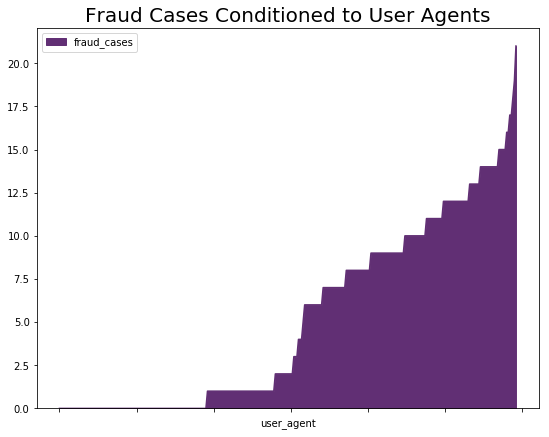

In [9]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
browser.sort_values('fraud_cases').plot(kind='area', color=main_color, ax=ax)
_ = ax.set_title('Fraud Cases Conditioned to User Agents', fontsize=20)

De fato, o padrão de fraude é muito distinto nos diversos *user agents*. Lembre da análise inicial dos dados, no *notebook* `01_data_cleaning_eda.ipynb`, que a variável `user_agent` possui 297 valores únicos e sabemos que existem 1522 casos de fraude e, dessa forma, temos cerca de 5 fraudes por *user agent*. Esse baixo valor pode criar problemas relacionados a *overfitting*.  
Vamos tentar melhorar essa estatística reduzindo o número de *user agents* únicos. Observe que cada *user agent* possui um número final no formato `xyz.ab`. Esse número está relacionado à versão de *release* do navegador e nós iremos removê-lo para criar a *feature* `shortned_user_agent`.
Observe a tabela e o gráfico anterior utilizando essa nova variável:

In [10]:
data = acquisition[['shortned_user_agent','target_fraud']]
browser = data.groupby('shortned_user_agent')['target_fraud'].sum().to_frame('fraud_cases')
display(browser.sort_values('fraud_cases'))

,fraud_cases
shortned_user_agent,
"Mozilla/5.0 (iPhone9,4; U; CPU iPhone OS 10_0_1 like Mac OS X) AppleWebKit/602.1.50 (KHTML, like Gecko) Version/10.0 Mobile/14A403 Safar",0
"Mozilla/5.0 (iPhone9,3; U; CPU iPhone OS 10_0_1 like Mac OS X) AppleWebKit/602.1.50 (KHTML, like Gecko) Version/10.0 Mobile/14A403 Safar",0
"Mozilla/5.0 (Linux; Android 7.1.1; G8231 Build/41.2.A.0.219; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/59.0.3071.125 Mobile Safari",0
"Mozilla/5.0 (Linux; Android 7.0; SM-G930VC Build/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/58.0.3029.83 Mobile Safari",0
"Mozilla/5.0 (Linux; Android 6.0.1; E6653 Build/32.2.A.0.253) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.98 Mobile Safari",0
"Mozilla/5.0 (Linux; Android 6.0.1; SM-G920V Build/MMB29K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.98 Mobile Safari",0
"Mozilla/5.0 (iPhone9,4; U; CPU iPhone OS 10_0_1 like Mac OS X) AppleWebKit/602.1.50 (KHTML, like Gecko) Version/10.0 Mobile/14A403 Safari",1
"Mozilla/5.0 (Linux; Android 5.1.1; SM-G928X Build/LMY47X) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.83 Mobile Safari",1
"Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like Mac OS X) AppleWebKit/604.1.38 (KHTML, like Gecko) Version/11.0 Mobile/15A5370a Safar",1


Agora temos uma nova *feature* com ótimo poder de discriminação de fraudes! Observe abaixo o gráfico anterior com essa nova variável

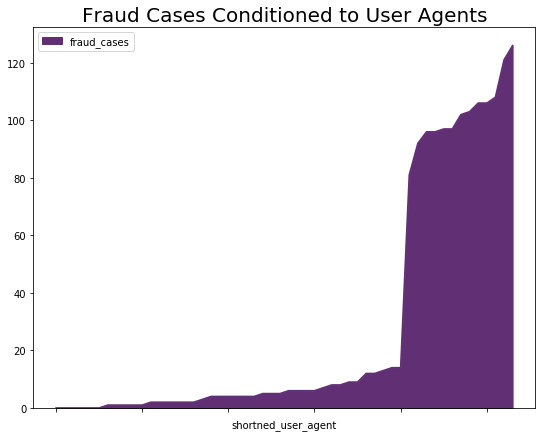

In [11]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
browser.sort_values('fraud_cases').plot(kind='area', color=main_color, ax=ax)
_ = ax.set_title('Fraud Cases Conditioned to User Agents', fontsize=20)

# Métricas <a name="06-metrics"></a>
Nesta seção, buscamos entender como os valores das métricas estatísticas se relacionam com a performance do negócio.  
Da mesma forma que no problema de modelagem de crédito, aqui buscamos identificar potênciais clientes que tragam prejuízo financeiro ao Nubank mas, diferentemente daquele problema, a identificação de fraude permite uma segunda validação por um colaborador da empresa.  
Note que, quando o modelo identifica um potencial cliente inadimplente, no momento da identificação e com os dados disponíveis naquele instante, não é possível realizar um verificação mais aprofundada já que a indimplência é uma previsão que pode, ou não, se realizar no futuro.  
No problema em questão, a identificação de um caso de fraude assume outra configuração. No momento da identificação, apesar dos dados disponíveis serem os mesmo do problema de modelagem de crédito, aqui a fraude de fato já existe, ou não. Perceba que estamos identificando uma situação presente e não fazendo uma previsão futura. Dessa forma, se nosso modelo apontar um potencial caso de fraude, um colocaborador pode entrar em cena e solicitar documentos ou procedimento adicionais ao solicitante do cartão de crédito.  
Dessa forma o impacto das previsões do modelo no negócio se configura no *trade-off* entre reduzir o impacto financeiro do número de fraudadores que passam despercebidos pelo modelo (Falsos Negativos) e o custo de manter uma estrutura capaz de realizar verificações adicionais no caso de indicação de fraude (Falso Positvos + Postivos Corretos).  
Rigorosamente falando, o *benchmark* desse modelo deveria ser a estrutura manual atual de verificação de fraudes, com sua taxa de sucesso e custo. Com isso, poderíamos mensurar precisamente o ganho financeiro do modelo como etapa intermediária de identificação.

Nesse problema, foi fornecida a premissa que permite avaliar financeiramente o impacto de fraudes. Na ausência da taxa de sucesso e custo de operação da estrutura de identificação de fraudes, faremos algumas suposições para viabilizar uma análise e mantê-la simples e objetiva.

Vamos começar por estimar o prejuízo esperado em uma solicitação fraudulenta de cartão de crédito. Como tratamos o problema como uma classificação binária, utilizaremos essa variável *target* para condicionar a análise.

Observações:
1. **Conforme afirmado no documento de descrição do projeto, considera-se o prejuízo de um fraudador como o valor total de seu limite de crédito**
2. **Os dados de gasto e rotativo já foram ajustados para inflação na função `load_data_preprocessed`**

Text(0.5,1,'Credit Line Distribution - Fraud')

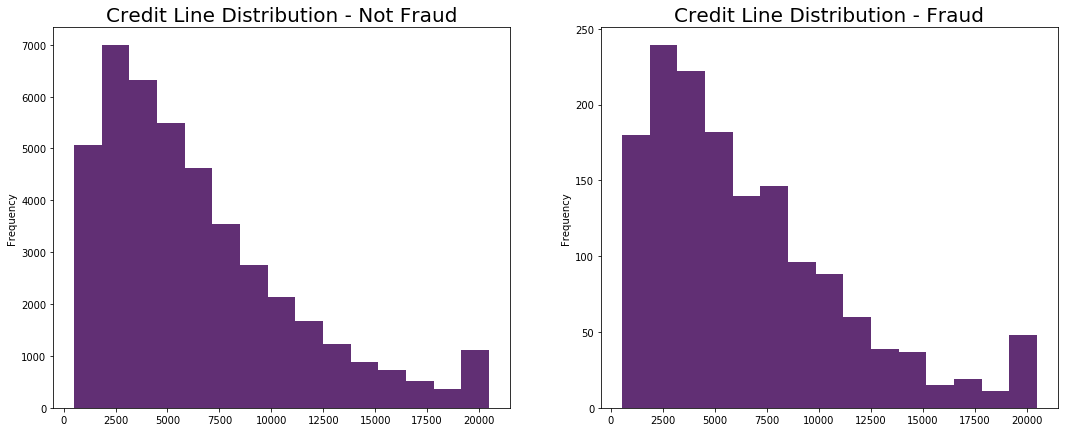

In [12]:
fraud_loss = acquisition[['ids','target_fraud']].merge(spend.groupby('ids')['credit_line'].nth(-1).reset_index(), how='left',on='ids')
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(121)
fraud_loss.loc[fraud_loss['target_fraud']==0,'credit_line'].plot.hist(bins=15, ax=ax, color=main_color)
ax.set_title('Credit Line Distribution - Not Fraud', fontsize=20)
ax = fig.add_subplot(122)
fraud_loss.loc[fraud_loss['target_fraud']==1,'credit_line'].plot.hist(bins=15, ax=ax, color=main_color)
ax.set_title('Credit Line Distribution - Fraud', fontsize=20)

Os gráficos acima mostram uma característica curiosa. A distribuição de limite de crédito de clientes legítimos é a mesma dos clientes fraudadores. Isso nos leva a crer que o processo de atribuíção de limite de crédito é ingênuo em relação à nossa variável target. 
Para dar um pouco mais de atenção a esse fato curioso, vamos realizar um teste simples para verificar se as distribuições são estatisticamente diferentes. A seguir procederemos com o teste de Kolmogorov-Smirnov para diferenciação de distribuições:

In [13]:
from scipy.stats import ks_2samp
display(ks_2samp(fraud_loss.loc[fraud_loss['target_fraud']==1,'credit_line'],fraud_loss.loc[fraud_loss['target_fraud']==0,'credit_line']))

Ks_2sampResult(statistic=0.024649891657562817, pvalue=0.32959225156358374)

Nesse teste, a hipótese nula é a de que as distribuição são diferentes. Note que com um *p-value* próximo de 32% não podemos afirmar que as distribuições são diferentes nem com um teste de 30% de significancia. Essa é mais uma indicação que as distribuições são iguais (apesar de que, rigorosamente, não podemos afirmar isso com absoluta certeza)

Já temos o prejuízo esperado num caso de fraude:

In [14]:
fraud_loss_df = (-fraud_loss.loc[fraud_loss['target_fraud']==1,'credit_line']).apply(['min','mean','max','std']).to_frame(name='Fraud Expected Loss')
display(fraud_loss_df.applymap('R$ {:,.2f}'.format))

,Fraud Expected Loss
min,"R$ -20,473.00"
mean,"R$ -6,553.30"
max,R$ -531.00
std,"R$ 4,621.89"


Como verificado anteriormente, no *notebook* `02_credit_risk_eda.ipynb`, o lucro esperado por um cliente legítimo e adimplente é de R\$4,603.28. Pereceba que o prejuízo de uma solicitação fraudulenta incorretamente aceita é, na média, aproximadamente 50% superior ao lucro de um cliente legítimo.

Como discutido anteriormente, nesse problema estamos preocupado com o número de Falsos Negativos e, por isso, uma métrica sensível ao *recall* é importante. **Utilizaremos, como habitualmente, *AUC ROC* e *Accuracy score* como métricas do modelo mas, para efetiva avaliação da performance, tendo em mente o *link* com as características do negócio, utilizaremos o *F2 score*.**

# *Feature Engineering* <a name="06-feat-eng"></a>
Nesta seção, mostraremos algumas novas *features* desenvolvidas à partir da análise exploratória realizada anteriormente. É importante frisar que esse é um processo com várias iterações do ciclo análise => implementação => testes => análise,  tendo, inclusive, *features* desenvolvidas neste *notebook* sido testadas nos outros modelos.

## Número de Telefone
Observe algumas amostras da variável `profile_phone_number'

In [15]:
display(raw_acquisition['profile_phone_number'].head(10))

0    514-9840782
1    251-3659293
2    230-6097993
3    261-3543751
4    102-3660162
5    787-1678197
6    185-7402507
7    503-9012277
8    750-4705041
9    132-3263001
Name: profile_phone_number, dtype: object

Esse padrão de número se mostra estranho se comparado aos típicos números de telefone atuais. No entanto, utilizamos os dois primeiros dígitos dos números como um *proxy* para o código de área. Além disso, criamos uma variável binária `profile_is_cellphone` que compara o terceiro dígito com o valor 9 e nos dá uma indicação se o número fornecido é de um telefone celular. Ambas *features* se mostraram de grande importância nos modelos utilizados

# Modelagem <a name="06-modeling"></a>
Nesta seção, descreveremos o modelo usados, o procedimento de treinamente e os resultados obtidos. Nós começamos por responder de forma concisa e objetiva o questionário pedido na seção **Tarefas** no Projeto Nubank, no portal da Udacity. Em seguida, seguiremos com uma análise mais profunda:

- **O que se está tentando prever?**  
Estamos tentando identificar os clientes realizando solicitações de cartões de crédito fraudulentas, isto é, em nome de terceiros. Note que não é, de fato, uma previsão e sim uma identificação. Nosso modelo retorna uma variável binária indicando se determinada solicitação de cartão de crédito configura uma fraude.

- **Qual foi o target (variável alvo) escolhido? Se optou-se por um modelo não supervisionado, qual o motivo?**  
A variável alvo utilizada foi fornecida na própria base de dados, sob o nome de `target_fraud`. Em seu formato original, ela possui 3 valores indicando 2 tipos de fraude e sua ausência. Em nosso problema, nós convertemos essa variável para um tipo binário e degeneramos os dois tipos de fraude em um único sinalizador. Dessa forma, nossa variável indica apenas a existência de fraude ou da ausência dela.

- **Quais variáveis foram selecionadas e qual foi o critério de seleção?**  
O critério de seleção de variáveis se dá, primeiro pela indicação de importância que os modelos baseados em àrvores de decisão possuem. Segundo, pelo monitoramente das métricas em experimentos com validação cruzada (*cross-validation*). A lista completa das variáveis selecionadas é apresentada à seguir.

- **Quais as variáveis mais importantes do seu modelo?**  
As variáveis que mostraram maior importância foram as relacionadas com os dispositivos utilizados para a solicitação de cartão de crédtido: `user_agent`, `profile_phone_number` e `facebook_profile`

- **Quais métricas foram selecionadas para a validação do modelo? O que cada uma delas significa de acordo com o contexto do que se está tentando prever? Quais evidências te fariam crer ou não de que a performance de validação será a mesma de quando este modelo estiver rodando de fato com novos dados?**  
Como discutido na seção **Métricas**, nós utilziamos como métrica principal o *F-2 score*. A relação dela com as condições do negócio podem ser consultada na seção já mencionada. Também utilizamos a métrica *accuracy*, que possui alta interpretabilidade e que pode ser compara com a precisão de um Model-Nulo que, no nosso caso, possui 96.6% de precisão. Por fim, utilizamos a métrica *AUC ROC* como uma espécie de distância do chute completamente aleatório. Durante o processo de treinamento, nós tivemos o cuidado de fazer do modelo um caso repodutível e confiável. Nós usamos validação cruzada estratificada para a seleção de variáveis e para estimar a performance do modelo. Além disso, em todas as transformações dos dados de entradas, nós nos preocupamos em evitar vazamento de dados (*data leakage*) e separamos uma fração de dados que se manteve intocada durante o processo de treinamente e foi usada ao final para termos uma validação de todo o processo.

## O Modelo
Nós construímos um *framework* para realização de experimentos de *machine learning* fortemente baseado no paradigmo utilizado pelo *scikit_learn*. Dessa forma, pudermos testar variados modelos daquele pacote sem nenhum esforço além do de configurar os hiperparâmetros. Apesar disso, acamos por utilizar um modelo externo à bilbioteca, o LighGBM, mantido pela *Microsoft*.  
Esse modelo é largamente utilizado na modelagem de uma ampla classe de problema e, aqui, se mostrou superior às opções testadas do *scikit-learn*. O LightGBM siginifica, literalmente, *Light Gradient Boosting Machine*. Ele é uma *framework* para utilização de *ensemble* de árvores de decisão guiados por *gradient boosting*. Dessa forma, o estado final do modelo se caracteriza por um conjunto de árvores de decisão, potencialmente com milhares delas. Seus parâmetros de configuração permitem uma série de configurações avançadas para um treinamento robusto, como *bootstrapping*, regularizações, *bining* de variáveis, amostragem de *features*, entre outros.
O lightgbm tem uma tendência de *ovefitting* e por isso a fase de *tuning* dos hiperparâmetros foi importante. Nesta etapa, o conhecemento do comportamento dos parâmetros também é muito importante pois, devido ao grande número de parâmetros e valores aceitos, é impraticável realizar um *grid-search* de amplot espectro. Nossa abordagem foi realizar o acerto grosseiro baseado no conhecimento dos parâmetros e realizar o ajuste fino via *grid-search * com validação cruzada.  
No problema atual, nós utilizamos uma configuração para classificação binária. Utilizando a função de entropia cruzada, o modelo crias as árvores de decisão e estima o resultado, nas folhas, através de contagem de votos das amostras classificadas.

## Validação Cruzada
Validação cruzada é sempre um tema sensível em *machine learning*. As pontos que vamos discutir aqui dizem respeito ao número de divisões nos dados, estratégia de divisão e vazamento de dados.
Utilizamos uma validação cruzada com conjuntos (*5-Fold Cross Validation*). Um impeditivo de utilizar um número maior foi o forte *class imbalance* encontrado nesse problema. Muitos conjuntos na validação cruzada levaria o conjunto de validação a apresentar poucas observações positivas. *Class imabalance* também foi determinante na escolha da estratégia de divisão dos dados. Utilizamos uma validação cruzada estratificada, onde a distribuição das classes positivas é mantida em toda partição. Isso mitigou o efeito de *folds* com poucas observações positivas em relação aos outros.  
Por fim, a questão de vazamento de dados foi resolvida com o uso de uma arquitetura adequada para o *framework* de experimentação. Nosso *framework* trabalha em duas fases: *fit* e *trasform*. Na primeira, podemos utilizas os dados como bem entendermos pois só teremos acessos aos dados de treinamento. Na segunda etapa, dados de validação poderam estar presentes, então só poderemos realizar transformações em uma única observação ou utilizar estatísticas coletadas na etapa anterior.

## *Missing Values*
Outra característica interessante desse modelo é que ele aceita a entrada de dados com valores faltantes (NaN). Na prática o que acontece é que ele trata esses valores como uma classes distinta (no case de uma variável categórica) ou um valor distinto (no caso de uma variável contínua). Embora essa característica seja muito apreciada, em nosso pipeline nós implementamos utilizamos um módulo de para preenchimento de valores faltantes. Quatro estratégias são possíveis:
1. `constant`: Assim como no lightgbm, esse método preenche os dados faltantes com um valor distinto dos presentes nos dados
2. `mean`: Preenche os dados faltantes contínuos com a média dos dados existentes
3. `median`: Preenche os dados faltantes contínuos com a mediana dos dados existentes
4. `most_frequent`: Preenche os dados faltantes categóricos com a categoria mais frequente

No nosso problema, utilizamos a estratégia `constant` para dados categóricos e `mean` para dados continuos. Essa configuração apresentou melhor performance com validação cruzada.

## Parâmetros e Seleção de Variáveis
Os principais parâmetros utilizados e seus valores foram:
- learning_rate: 0.004
- n_estimators: 8000
- max_depth: 3
- num_leaves: 3
- max_bin: 256
- subsample: 0.9
- subsample_freq: 1
- colsample_bytree: 0.15
- min_data_in_leaf: 50
- verbose: 1
- categorical_feature: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
- early_stopping_rounds: 750
- scale_pos_weight: 2.5
- seed: 1234
- min_data_per_group: 250
- max_cat_threshold: 128
        
Não entraremos na desnecessária descrição e explicação dos parâmetros pois isso só tornaria essa seção tediosa. O único ponto a acrescentar diz respeito ao parâmetro `categorical_feature` que indica a posição das variáveis categóricas em nossa matriz de dados de entrada. Aqui, notamos que utilizamos um total de 24 variáveis categóricas.  
Como dito anteriormente, nosso processo de seleção de variáveis utilizou dois elementos. O primeiro foi o teste de performance, observando-se as métricas, em experimentos com validação cruzada. O segundo foi a utilização de gráficos de importância de variáveis, tradicionalmente disponíveis em modelos baseados em árvores de decisão.
Todas as variáveis e sua importância para o modelo podem ser vistas abaixo. A descrição detalhada delas pode ser encontrada no documento `engineered_features_guide.md`        

<img src="images/importances_fraud_detection.png" width=800 height=900>

## Resultados
Nesta seção discutiremos os resultados do modelos. Todos os dados desta seção dizem respeito ao conjunto de validação que foi previamente separado e não foi utilizado no treinamento.
Iniciaremos apresentando a proporção de casos de fraude identificados pelo modelo:

<img src="images/target_pie_fraud_detection.png" width=1200 height=1400>

Verificamos que o modelo final identificou cerca de 4.2% das amostras como casos de fraude, valor um pouco superior ao da realidade. Note que este problema apresenta um problema de desbalanceamento ainda mais grave do que o problema de modelagem de crédito. Vamos, agora, observar a matriz de confusão do classificador para conhecer a proporção de casos identificados corretamente e incorretamente:

<img src="images/confusion_matrix_fraud_detection.png" width=800 height=900>

Vemos que o modelo identificou corretamente 67 casos de fraude mas perdeu 80 casos positivos. Como dito anteriormente, aqui existe um *trade-off*. Podemos aumentar o peso das classes positivas (parâmetro `scale_pos_weight`) e assim classificar um maior número de fraudes incorrendo no custo de um maior número de falsos positivos. Nesse tipo de problema, uma identificação positiva pode *triggar* a atuação de um operador humano, que poderia realizar etapas adicionais de validação da identidade do solicitante do cartão de crédito. O ponto de equilíbrio e o limiar no qual o modelo começa a fazer sentido, depende do custo de operação e da taxa de sucesso dessa equipe de análise de casos suspeitos.  
Por exemplo, vamos assumir que a equipe de análise de solicitações suspeitas tenha uma taxa de sucesso de 80%. Nesse caso, 80% dos 67 casos sinalizados como fraude seriam, de fato, identificados assumimos que nenhum caso de falso negativo teria tido a solicitação rejeitada. Com prejuízo esperado de R\$ 6,553.30 por cliente fraudulento, nossa equipe estará no ponto de *break even* se tiver um custo de operação de R\$ 351,256.88 no período de abrangência dos dados. Nesse período, ele terão avaliado 187 casos dos quais 54 foram identificados como fraude.

Vamos agora analisar as métricas do modelo:

In [18]:
metrics_df = pd.DataFrame(np.atleast_2d([0.955556,0.714108,0.432258]), columns=['Accuracy','AUC ROC','Beta-2'], index=['Fraud_Detection'])
display(metrics_df)

,Accuracy,AUC ROC,Beta-2
Fraud_Detection,0.955556,0.714108,0.432258


O modelo final terminou com uma precisão ligeiramente inferior à proporção incondicional de fraudes nos dados. Temos, entretanto, um score AUROC de 71% que nos dá uma indicação de algum poder preditivo, estando acima do chule completamente aleatório. Novamente nesse modelo, a métrica *F-beta* foi utilizada principalmente para comparações entre modelos, is.to é, comparação do valor relativo.
Temos aqui mais um modelo inicial que poderia servir de ponto de partida para uma modelagem mais robusta e com uma maior quantidade de dados, visto que esse problema apresenta forte *class imbalance*.